In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pandas.plotting import scatter_matrix
import seaborn as sns

df_test = pd.read_csv("/Users/guillaumequispe/PycharmProjects/Guillaume_QUISPE/INF701/test-set.csv")
df_train = pd.read_csv("/Users/guillaumequispe/PycharmProjects/Guillaume_QUISPE/INF701/train-set.csv")


In [16]:
df_train.describe()


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,528720.0000,528720.000000,528720.000000,528720.000000,528720.000000,528720.000000,528720.000000,528720.000000,528720.000000,528720.000000,...,528720.000000,528720.000000,528720.000000,528720.000000,528720.000000,528720.000000,528720.000000,528720.000000,528720.000000,528720.000000
mean,264360.5000,2959.800552,155.629891,14.095043,269.731845,46.474718,2352.595141,212.153062,223.343970,142.555615,...,0.090365,0.077678,0.002792,0.003276,0.000202,0.000471,0.026916,0.023646,0.015118,2.052294
std,152628.4615,280.351766,112.095470,7.501853,213.069124,58.433933,1563.557679,26.793767,19.813479,38.336178,...,0.286705,0.267665,0.052762,0.057141,0.014224,0.021696,0.161838,0.151943,0.122021,1.396863
min,1.0000,1759.000000,-72.000000,-3.000000,-144.000000,-182.000000,-805.000000,-2.000000,0.000000,-17.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,132180.7500,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,264360.5000,2996.000000,127.000000,13.000000,223.000000,30.000000,2001.000000,218.000000,226.000000,143.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,396540.2500,3163.000000,260.000000,18.000000,387.000000,69.000000,3333.000000,231.000000,237.000000,168.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,528720.0000,3957.000000,440.000000,65.000000,1397.000000,601.000000,7577.000000,268.000000,266.000000,259.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [17]:
df_train.groupby('Cover_Type').size()

Cover_Type
1    192511
2    257989
3     32598
4      2503
5      8676
6     15687
7     18756
dtype: int64

In [18]:
print(df_train[:100].shape)
Xc=df_train[:100]

(100, 56)


In [19]:
#scatter_matrix(df_train[:56], figsize=(6, 6), diagonal='kde')

In [20]:
dst=np.array([df_train['Horizontal_Distance_To_Hydrology'], df_train['Vertical_Distance_To_Hydrology']])
df_train["Horizontal_Distance_To_Hydrology"]=np.sqrt(df_train['Horizontal_Distance_To_Hydrology']**2+df_train['Vertical_Distance_To_Hydrology']**2)
df_train=df_train.drop(['Vertical_Distance_To_Hydrology'], axis=1)

In [21]:
df_test["Horizontal_Distance_To_Hydrology"]=np.sqrt(df_test['Horizontal_Distance_To_Hydrology']**2+df_test['Vertical_Distance_To_Hydrology']**2)
df_test=df_test.drop(['Vertical_Distance_To_Hydrology'], axis=1)

In [22]:
print(df_test.shape)
print(df_train.shape)

(226595, 54)
(528720, 55)


In [23]:
df_train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2611,326,20,123.000000,1597,168,214,184,2913,...,0,0,0,0,0,0,0,0,0,6
1,2,2772,324,17,42.579338,1814,175,220,183,2879,...,0,0,0,0,0,0,0,0,0,2
2,3,2764,4,14,480.459155,700,201,212,148,700,...,0,0,0,0,0,0,0,0,0,2
3,4,3032,342,9,60.530984,4050,202,227,164,2376,...,0,0,0,0,0,0,0,0,0,2
4,5,2488,23,11,118.869677,1117,209,218,151,1136,...,0,0,0,0,0,0,0,0,0,2


In [24]:
df_train=df_train.set_index("Id")
df_test=df_test.set_index("Id")


df_train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Id,,,,,,,,,,,,,,,,,,,,,
1,2611,326,20,123.000000,1597,168,214,184,2913,0,...,0,0,0,0,0,0,0,0,0,6
2,2772,324,17,42.579338,1814,175,220,183,2879,1,...,0,0,0,0,0,0,0,0,0,2
3,2764,4,14,480.459155,700,201,212,148,700,0,...,0,0,0,0,0,0,0,0,0,2
4,3032,342,9,60.530984,4050,202,227,164,2376,1,...,0,0,0,0,0,0,0,0,0,2
5,2488,23,11,118.869677,1117,209,218,151,1136,0,...,0,0,0,0,0,0,0,0,0,2


In [25]:
x=df_train.drop(columns=["Cover_Type"])
y=df_train[["Cover_Type"]]
print(x.shape)
print(y.shape)

(528720, 53)
(528720, 1)


In [26]:
x[x.columns[0:9]].head()


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
Id,,,,,,,,,
1,2611,326,20,123.000000,1597,168,214,184,2913
2,2772,324,17,42.579338,1814,175,220,183,2879
3,2764,4,14,480.459155,700,201,212,148,700
4,3032,342,9,60.530984,4050,202,227,164,2376
5,2488,23,11,118.869677,1117,209,218,151,1136


In [27]:
xstd=x
scaler = StandardScaler()
xsc=scaler.fit_transform(xstd[xstd.columns[0:9]])

xstd[xstd.columns[0:9]]=xsc
xstd.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,5.287200e+05,5.287200e+05,5.287200e+05,5.287200e+05,5.287200e+05,5.287200e+05,5.287200e+05,5.287200e+05,5.287200e+05,528720.000000,...,528720.000000,528720.000000,528720.000000,528720.000000,528720.000000,528720.000000,528720.000000,528720.000000,528720.000000,528720.000000
mean,-1.244591e-17,2.796398e-17,4.466147e-17,-5.498460e-16,2.449328e-17,-4.885964e-16,-1.762399e-16,5.369542e-16,-1.161396e-17,0.448795,...,0.043859,0.090365,0.077678,0.002792,0.003276,0.000202,0.000471,0.026916,0.023646,0.015118
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.497372,...,0.204781,0.286705,0.267665,0.052762,0.057141,0.014224,0.021696,0.161838,0.151943,0.122021
min,-4.283196e+00,-2.030681e+00,-2.278778e+00,-1.274859e+00,-2.019496e+00,-7.992652e+00,-1.127234e+01,-4.162016e+00,-2.023842e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-5.378981e-01,-8.709539e-01,-6.791719e-01,-7.748047e-01,-7.972820e-01,-5.282227e-01,-5.220678e-01,-6.144493e-01,-7.205529e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.291216e-01,-2.554066e-01,-1.459698e-01,-2.149588e-01,-2.248689e-01,2.182203e-01,1.340518e-01,1.159179e-02,-2.031592e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.248024e-01,9.310832e-01,5.205328e-01,5.428807e-01,6.270353e-01,7.034082e-01,6.892299e-01,6.637179e-01,4.303840e-01,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.556961e+00,2.536859e+00,6.785657e+00,5.261103e+00,3.341360e+00,2.084328e+00,2.152881e+00,3.037457e+00,4.199966e+00,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
x.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,5.287200e+05,5.287200e+05,5.287200e+05,5.287200e+05,5.287200e+05,5.287200e+05,5.287200e+05,5.287200e+05,5.287200e+05,528720.000000,...,528720.000000,528720.000000,528720.000000,528720.000000,528720.000000,528720.000000,528720.000000,528720.000000,528720.000000,528720.000000
mean,-1.244591e-17,2.796398e-17,4.466147e-17,-5.498460e-16,2.449328e-17,-4.885964e-16,-1.762399e-16,5.369542e-16,-1.161396e-17,0.448795,...,0.043859,0.090365,0.077678,0.002792,0.003276,0.000202,0.000471,0.026916,0.023646,0.015118
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.497372,...,0.204781,0.286705,0.267665,0.052762,0.057141,0.014224,0.021696,0.161838,0.151943,0.122021
min,-4.283196e+00,-2.030681e+00,-2.278778e+00,-1.274859e+00,-2.019496e+00,-7.992652e+00,-1.127234e+01,-4.162016e+00,-2.023842e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-5.378981e-01,-8.709539e-01,-6.791719e-01,-7.748047e-01,-7.972820e-01,-5.282227e-01,-5.220678e-01,-6.144493e-01,-7.205529e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.291216e-01,-2.554066e-01,-1.459698e-01,-2.149588e-01,-2.248689e-01,2.182203e-01,1.340518e-01,1.159179e-02,-2.031592e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.248024e-01,9.310832e-01,5.205328e-01,5.428807e-01,6.270353e-01,7.034082e-01,6.892299e-01,6.637179e-01,4.303840e-01,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.556961e+00,2.536859e+00,6.785657e+00,5.261103e+00,3.341360e+00,2.084328e+00,2.152881e+00,3.037457e+00,4.199966e+00,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


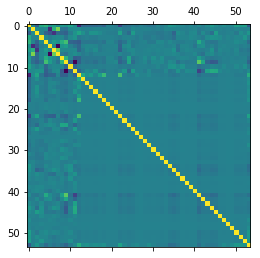

In [29]:
plt.matshow(df_train.corr())

(100, 54)


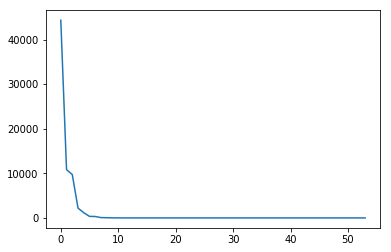

In [30]:
df1 = df_train[:100]
print(df1.shape)
u,s,v = np.linalg.svd(df1)
plt.plot(s)
plt.show()

In [31]:
pd.DataFrame(s<10**-7)[0].value_counts()

False    38
True     16
Name: 0, dtype: int64

In [32]:
pcax = PCA(n_components=41)
xpc=pcax.fit(xstd)
xpca=xpc.transform(xstd)


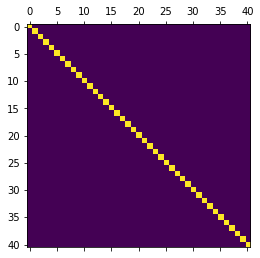

In [33]:
plt.matshow(pd.DataFrame(xpca).corr())

In [34]:
#scatter_matrix(pd.DataFrame(xpca[:100]), figsize=(6, 6), diagonal='kde')

In [35]:
X_train, X_test, y_train, y_test = train_test_split(xpca, y, test_size=0.2, random_state=30)

In [36]:
y_train.head()
y_train=y_train.values.ravel()

In [66]:
forest = ExtraTreesClassifier(n_estimators=40,random_state=0)
forest.fit(X_train, y_train)
ypred=forest.predict(X_test)
f1scorem=f1_score(y_test, ypred, average="macro")
f1scorew=f1_score(y_test, ypred, average="weighted")
print(f1scorem)
print(f1scorew)





0.8888327097574
0.9310140675146606


In [38]:
x_test_std=df_test
scaler = StandardScaler()
x_test_sc=scaler.fit_transform(x_test_std[x_test_std.columns[0:9]])

x_test_std[x_test_std.columns[0:9]]=x_test_sc

x_test_pca=xpc.transform(x_test_std)
ypredtest=forest.predict(x_test_pca)

#prediction = pd.DataFrame(predictions, columns=['Cover_Type']).to_csv('prediction.csv')


[2 2 2 ... 7 3 2]


In [62]:
#conc=np.concatenate((df_test.index.get_values(), ypredtest), axis=1)
cc=pd.DataFrame(df_test.index)
cc["Cover_Type"]=ypredtest
cc.head()
cc=cc.set_index("Id")
cc.head()
prediction = pd.DataFrame(cc).to_csv('prediction.csv')



In [ ]:
'''
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(
                              random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'max_depth': [20,30],
                    'n_estimators':[100,200]}]
clf = GridSearchCV(forest, tuned_parameters, cv=5,
                       scoring="f1_weighted")
clf.fit(X_train, y_train.values.ravel())

forest.fit(X_train, y_train.values.ravel())
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print("ok")
'''

In [ ]:
print(clf.best_params_)
print(clf.cv_results_)

In [ ]:
clf.score(X_test, y_test.values.ravel())

In [ ]:
ypred=forest.predict(X_test)
f1scorem=f1_score(y_test.values.ravel(), ypred, average="macro")
f1scorew=f1_score(y_test.values.ravel(), ypred, average="weighted")
print(f1scorem)
print(f1scorew)


In [ ]:
score= forest.score(X_test,y_test.values.ravel())

print( score)
f1_score=f1_score(y_test, ypred)

In [ ]:

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()